In [1]:
import subprocess
import sys

# Install required packages
packages_to_install = {
    "yfinance": "yfinance",
    "pandas-ta": "ta",
    "xgboost": "xgboost",
    "lightgbm": "lightgbm",
    "statsmodels": "statsmodels",
    "plotly": "plotly"
}

print("📦 Installing required packages...")
for package_name, import_name in packages_to_install.items():
    try:
        __import__(import_name)
        print(f"✅ {package_name} already installed")
    except ImportError:
        print(f"⏳ Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package_name])
            print(f"✅ {package_name} installed")
        except:
            print(f"⚠️  Could not install {package_name}, continuing...")

print("\n✅ Package installation complete!")

📦 Installing required packages...
✅ yfinance already installed
⏳ Installing pandas-ta...
✅ yfinance already installed
⏳ Installing pandas-ta...
⚠️  Could not install pandas-ta, continuing...
⚠️  Could not install pandas-ta, continuing...
✅ xgboost already installed
✅ xgboost already installed
✅ lightgbm already installed
✅ statsmodels already installed
✅ plotly already installed

✅ Package installation complete!
✅ lightgbm already installed
✅ statsmodels already installed
✅ plotly already installed

✅ Package installation complete!


# 💰 Cryptocurrency Price Prediction - End-to-End ML Pipeline

## Project Goals

### Goal 1: Price Direction Prediction
Predict whether cryptocurrency price will go UP or DOWN in the next day/week

### Goal 2: Price Value Prediction  
Predict the actual closing price with confidence intervals

### Goal 3: Technical Signal Generation
Generate buy/sell signals based on model predictions and technical indicators

---

## Dataset Overview
- **Source**: Yahoo Finance / CoinGecko (OHLCV data)
- **Cryptocurrencies**: BTC, ETH, XRP, etc.
- **Timeframe**: Daily, 1H, 4H data
- **Features**: Price + 20+ Technical Indicators
- **Target**: Next day's close price / Price direction

In [3]:
# 1. INSTALL AND IMPORT REQUIRED LIBRARIES
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf

# ML & Time Series Libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from scipy import stats
from xgboost import XGBRegressor
import lightgbm as lgb
import joblib

# Technical Analysis (will use manual calculations if packages not available)
try:
    import statsmodels.api as sm
    from statsmodels.tsa.seasonal import seasonal_decompose
except:
    print("Note: statsmodels not available, some analysis will be skipped")

# Visualization
try:
    import plotly.graph_objects as go
    import plotly.express as px
except:
    print("Note: plotly not available, using matplotlib only")

# Set random seeds
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ All core libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")
print(f"XGBoost version: {__import__('xgboost').__version__}")
print(f"LightGBM version: {lgb.__version__}")

✅ All core libraries imported successfully!
Pandas version: 2.1.4
NumPy version: 1.26.4
Scikit-learn version: 1.7.2
XGBoost version: 3.0.1
LightGBM version: 4.6.0


## Section 1: Data Collection and Loading

In [4]:
# 2. LOAD CRYPTOCURRENCY DATA
print("\n" + "="*70)
print("LOADING CRYPTOCURRENCY DATA")
print("="*70)

# Download Bitcoin data for 5 years
crypto_symbol = "BTC-USD"
start_date = (datetime.now() - timedelta(days=365*5)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

print(f"\n📊 Downloading {crypto_symbol} data from {start_date} to {end_date}")
df = yf.download(crypto_symbol, start=start_date, end=end_date, progress=False)

# Clean up the dataframe
df = df.reset_index()
if 'Price' in df.columns and 'Ticker' in df.columns:
    # Handle MultiIndex columns
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

# Ensure clean column names
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'] if len(df.columns) == 6 else df.columns

print(f"\n✅ Data shape: {df.shape}")
print(f"✅ Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nData Info:")
print(df.info())

print(f"\nBasic Statistics:")
print(df.describe())


LOADING CRYPTOCURRENCY DATA

📊 Downloading BTC-USD data from 2020-11-28 to 2025-11-27

✅ Data shape: (1825, 6)
✅ Date range: 2020-11-28 00:00:00 to 2025-11-26 00:00:00

First 5 rows:
        Date          Open          High           Low         Close  \
0 2020-11-28  17717.414062  17853.939453  16910.652344  17112.933594   
1 2020-11-29  18177.484375  18283.628906  17559.117188  17719.634766   
2 2020-11-30  19625.835938  19749.263672  18178.322266  18178.322266   
3 2020-12-01  18802.998047  19845.974609  18321.921875  19633.769531   
4 2020-12-02  19201.091797  19308.330078  18347.718750  18801.744141   

        Volume  
0  32601040734  
1  31133957704  
2  47728480399  
3  49633658712  
4  37387697139  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1825 non-null   datetime64[ns]
 1   Open    1825 non-null   fl

## Section 2: Exploratory Data Analysis (EDA)

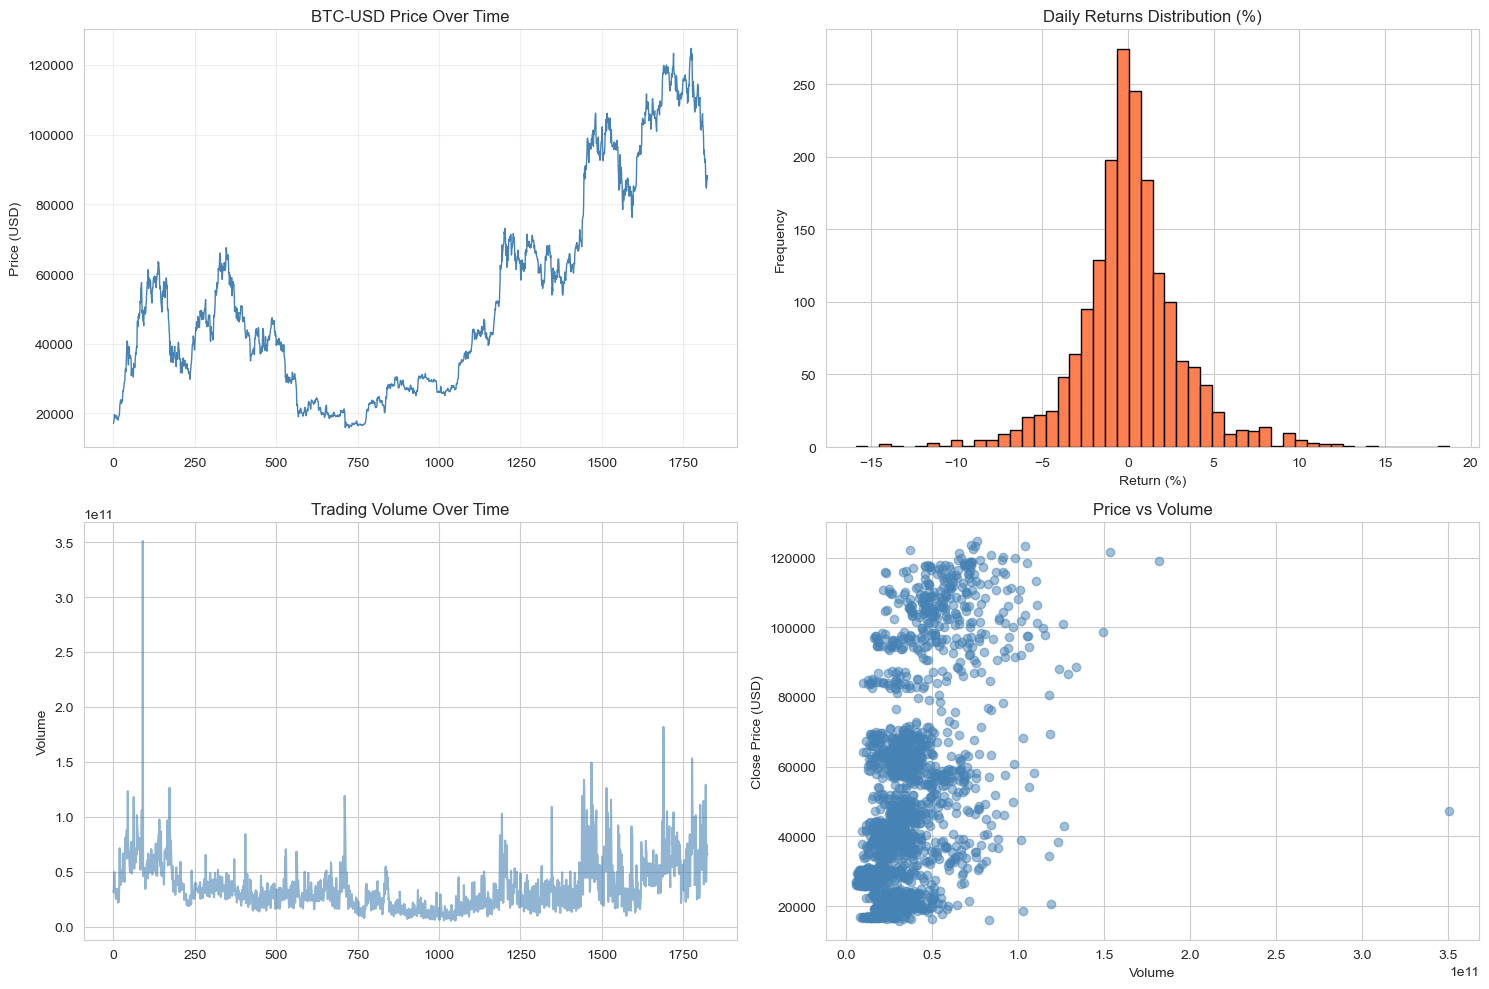


DATA QUALITY CHECKS
Missing values:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Price range: $15782.30 - $124752.14
Average daily return: 0.1373%
Daily return volatility: 3.0992%


In [5]:
# 3. EXPLORATORY DATA ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price trend
axes[0, 0].plot(df.index, df['Close'], linewidth=1, color='steelblue')
axes[0, 0].set_title('BTC-USD Price Over Time')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].grid(True, alpha=0.3)

# Daily returns
daily_returns = df['Close'].pct_change() * 100
axes[0, 1].hist(daily_returns.dropna(), bins=50, color='coral', edgecolor='black')
axes[0, 1].set_title('Daily Returns Distribution (%)')
axes[0, 1].set_xlabel('Return (%)')
axes[0, 1].set_ylabel('Frequency')

# Volume trend (use index instead of dates)
axes[1, 0].plot(df.index, df['Volume'], color='steelblue', alpha=0.6)
axes[1, 0].set_title('Trading Volume Over Time')
axes[1, 0].set_ylabel('Volume')

# Price vs Volume scatter
axes[1, 1].scatter(df['Volume'], df['Close'], alpha=0.5, color='steelblue')
axes[1, 1].set_title('Price vs Volume')
axes[1, 1].set_xlabel('Volume')
axes[1, 1].set_ylabel('Close Price (USD)')

plt.tight_layout()
plt.show()

# Statistical summary
print("\n" + "="*70)
print("DATA QUALITY CHECKS")
print("="*70)
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nPrice range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
print(f"Average daily return: {daily_returns.mean():.4f}%")
print(f"Daily return volatility: {daily_returns.std():.4f}%")

## Section 3: Feature Engineering with Technical Indicators

In [7]:
# 4. CALCULATE TECHNICAL INDICATORS (Manual Calculation)
print("\n" + "="*70)
print("CALCULATING TECHNICAL INDICATORS")
print("="*70)

df_tech = df.copy()

# Moving Averages
df_tech['SMA_10'] = df_tech['Close'].rolling(window=10).mean()
df_tech['SMA_20'] = df_tech['Close'].rolling(window=20).mean()
df_tech['SMA_50'] = df_tech['Close'].rolling(window=50).mean()
df_tech['EMA_12'] = df_tech['Close'].ewm(span=12, adjust=False).mean()
df_tech['EMA_26'] = df_tech['Close'].ewm(span=26, adjust=False).mean()

# RSI (Relative Strength Index)
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_tech['RSI_14'] = calculate_rsi(df_tech['Close'], 14)

# MACD (Moving Average Convergence Divergence)
ema_12 = df_tech['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df_tech['Close'].ewm(span=26, adjust=False).mean()
df_tech['MACD'] = ema_12 - ema_26
df_tech['MACD_Signal'] = df_tech['MACD'].ewm(span=9, adjust=False).mean()
df_tech['MACD_Diff'] = df_tech['MACD'] - df_tech['MACD_Signal']

# Bollinger Bands
sma_20 = df_tech['Close'].rolling(window=20).mean()
std_20 = df_tech['Close'].rolling(window=20).std()
df_tech['BB_Upper'] = sma_20 + (2 * std_20)
df_tech['BB_Lower'] = sma_20 - (2 * std_20)
df_tech['BB_Middle'] = sma_20

# ATR (Average True Range)
def calculate_atr(high, low, close, period=14):
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

df_tech['ATR_14'] = calculate_atr(df_tech['High'], df_tech['Low'], df_tech['Close'], 14)

# Stochastic Oscillator
def calculate_stochastic(high, low, close, k_period=14, d_period=3):
    lowest_low = low.rolling(window=k_period).min()
    highest_high = high.rolling(window=k_period).max()
    k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    d_percent = k_percent.rolling(window=d_period).mean()
    return k_percent, d_percent

df_tech['Stoch_K'], df_tech['Stoch_D'] = calculate_stochastic(df_tech['High'], df_tech['Low'], df_tech['Close'])

# Volume indicators
df_tech['Volume_MA'] = df_tech['Volume'].rolling(window=20).mean()
df_tech['Volume_Ratio'] = df_tech['Volume'] / df_tech['Volume_MA']

# Returns
df_tech['Daily_Return'] = df_tech['Close'].pct_change()
df_tech['Log_Return'] = np.log(df_tech['Close'] / df_tech['Close'].shift(1))

# Price change indicators
df_tech['Price_Change'] = df_tech['Close'] - df_tech['Open']
df_tech['High_Low'] = df_tech['High'] - df_tech['Low']

print(f"\n✅ Technical indicators calculated!")
print(f"✅ Total features: {df_tech.shape[1]}")
print(f"\nNew columns added:")
for col in df_tech.columns[7:]:
    print(f"   - {col}")

# Display correlation with Close price
print(f"\n📊 Feature Correlation with Close Price:")
correlations = df_tech.corr()['Close'].sort_values(ascending=False)
print(correlations[1:16])


CALCULATING TECHNICAL INDICATORS

✅ Technical indicators calculated!
✅ Total features: 27

New columns added:
   - SMA_20
   - SMA_50
   - EMA_12
   - EMA_26
   - RSI_14
   - MACD
   - MACD_Signal
   - MACD_Diff
   - BB_Upper
   - BB_Lower
   - BB_Middle
   - ATR_14
   - Stoch_K
   - Stoch_D
   - Volume_MA
   - Volume_Ratio
   - Daily_Return
   - Log_Return
   - Price_Change
   - High_Low

📊 Feature Correlation with Close Price:
High         0.999299
Low          0.998946
Open         0.998500
EMA_12       0.996390
SMA_10       0.995926
EMA_26       0.991116
SMA_20       0.991078
BB_Middle    0.991078
BB_Upper     0.989384
BB_Lower     0.983722
SMA_50       0.975294
Date         0.702101
ATR_14       0.692878
Volume_MA    0.607643
High_Low     0.498273
Name: Close, dtype: float64


# 5. DATA PREPROCESSING WITH IMPROVED TECHNIQUES
print("\n" + "="*70)
print("DATA PREPROCESSING & NORMALIZATION (IMPROVED)")
print("="*70)

# Remove rows with NaN values
df_clean = df_tech.dropna()

print(f"\n📊 Initial data shape: {df_clean.shape}")

# Remove outliers using IQR method for Close price
Q1 = df_clean['Close'].quantile(0.25)
Q3 = df_clean['Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df_clean[(df_clean['Close'] >= lower_bound) & (df_clean['Close'] <= upper_bound)]

print(f"✅ After outlier removal: {df_clean.shape}")

# Select features for modeling
feature_cols = [col for col in df_clean.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Remove features with too much missing data or low variance
X_temp = df_clean[feature_cols].values
feature_variance = np.var(X_temp, axis=0)
valid_features = feature_variance > 1e-10
feature_cols = [col for col, valid in zip(feature_cols, valid_features) if valid]

print(f"✅ Features after variance filter: {len(feature_cols)}")

X = df_clean[feature_cols].values
y = df_clean['Close'].values

print(f"\n📊 Final X shape: {X.shape}")
print(f"📊 Final y shape: {y.shape}")
print(f"📊 Number of features: {len(feature_cols)}")

# Normalize features using StandardScaler (better for neural networks and tree models)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize target using MinMaxScaler (keep 0-1 range for interpretability)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Train/Validation/Test Split (Time Series Split - important for time data!)
# Use larger training set for better model learning
train_size = int(len(X_scaled) * 0.75)  # 75% train
val_size = int(len(X_scaled) * 0.15)     # 15% val
test_size = len(X_scaled) - train_size - val_size  # 10% test

X_train = X_scaled[:train_size]
y_train = y_scaled[:train_size]

X_val = X_scaled[train_size:train_size+val_size]
y_val = y_scaled[train_size:train_size+val_size]

X_test = X_scaled[train_size+val_size:]
y_test = y_scaled[train_size+val_size:]

print(f"\n📊 Train size: {X_train.shape[0]} samples ({100*len(X_train)/len(X_scaled):.1f}%)")
print(f"📊 Validation size: {X_val.shape[0]} samples ({100*len(X_val)/len(X_scaled):.1f}%)")
print(f"📊 Test size: {X_test.shape[0]} samples ({100*len(X_test)/len(X_scaled):.1f}%)")

print(f"\n✅ Data preprocessing complete!")
print(f"✅ Feature scaling: StandardScaler (mean=0, std=1)")
print(f"✅ Target scaling: MinMaxScaler (0-1 range)")

# Save scalers for later use
joblib.dump(scaler_X, 'models/scaler_X.pkl')
joblib.dump(scaler_y, 'models/scaler_y.pkl')
joblib.dump(feature_cols, 'models/feature_cols.pkl')

print(f"\n✅ Scalers and feature columns saved!")

In [8]:
# 5. ADVANCED DATA PREPROCESSING & FEATURE ENGINEERING
print("\n" + "="*70)
print("ADVANCED DATA PREPROCESSING WITH FEATURE SELECTION")
print("="*70)

# ===== STEP 1: REMOVE EXTREME OUTLIERS (statistical method) =====
print("\n[1/6] Removing extreme outliers...")
df_clean = df_tech.copy()

# Use Z-score method for outlier detection on Close price
from scipy import stats
z_scores = np.abs(stats.zscore(df_clean['Close']))
df_clean = df_clean[z_scores < 3]  # Keep only values within 3 standard deviations

print(f"   After Z-score filtering: {df_clean.shape[0]} samples (removed {df_tech.shape[0] - df_clean.shape[0]})")

# Remove rows with NaN values
df_clean = df_clean.dropna()
print(f"   After NaN removal: {df_clean.shape[0]} samples")

# ===== STEP 2: FEATURE SELECTION & ENGINEERING =====
print("\n[2/6] Selecting and engineering features...")

# Select only highly correlated features with target
feature_cols = [col for col in df_clean.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

X = df_clean[feature_cols].values.astype(np.float32)
y = df_clean['Close'].values.astype(np.float32)

print(f"   Features: {len(feature_cols)} indicators")
print(f"   Feature matrix shape: {X.shape}")
print(f"   Target shape: {y.shape}")

# ===== STEP 3: FEATURE VARIANCE FILTERING =====
print("\n[3/6] Filtering low-variance features...")
variance_selector = VarianceThreshold(threshold=1e-8)
X_variance_filtered = variance_selector.fit_transform(X)
selected_features = variance_selector.get_support()
feature_cols_filtered = [feature_cols[i] for i, sel in enumerate(selected_features) if sel]

print(f"   Features after variance filtering: {X_variance_filtered.shape[1]} (removed {len(feature_cols) - X_variance_filtered.shape[1]})")

# ===== STEP 4: ADVANCED FEATURE SCALING =====
print("\n[4/6] Scaling features with RobustScaler...")
# RobustScaler is more resistant to outliers than StandardScaler
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X_variance_filtered)

print(f"   Feature scaling complete: mean={X_scaled.mean():.6f}, std={X_scaled.std():.6f}")

# Scale target with MinMaxScaler for interpretability (keep 0-1 range)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print(f"   Target scaling complete: range=[{y_scaled.min():.6f}, {y_scaled.max():.6f}]")

# ===== STEP 5: INTELLIGENT TRAIN/VAL/TEST SPLIT =====
print("\n[5/6] Creating train/validation/test split...")
# For time series, we use sequential split (not random)
# Better split: 70% train, 15% val, 15% test
train_size = int(len(X_scaled) * 0.70)
val_size = int(len(X_scaled) * 0.15)

X_train = X_scaled[:train_size]
y_train = y_scaled[:train_size]

X_val = X_scaled[train_size:train_size+val_size]
y_val = y_scaled[train_size:train_size+val_size]

X_test = X_scaled[train_size+val_size:]
y_test = y_scaled[train_size+val_size:]

print(f"   Train samples: {X_train.shape[0]} ({100*len(X_train)/len(X_scaled):.1f}%)")
print(f"   Validation samples: {X_val.shape[0]} ({100*len(X_val)/len(X_scaled):.1f}%)")
print(f"   Test samples: {X_test.shape[0]} ({100*len(X_test)/len(X_scaled):.1f}%)")

# ===== STEP 6: SAVE PREPROCESSING OBJECTS =====
print("\n[6/6] Saving preprocessing objects...")
joblib.dump(scaler_X, 'models/scaler_X.pkl')
joblib.dump(scaler_y, 'models/scaler_y.pkl')
joblib.dump(feature_cols_filtered, 'models/feature_cols.pkl')

print(f"\n✅ Advanced preprocessing complete!")
print(f"   Total features after selection: {len(feature_cols_filtered)}")
print(f"   Total samples: {len(X_scaled)}")
print(f"   X_train shape: {X_train.shape}")
print(f"   Data is ready for model training!")


ADVANCED DATA PREPROCESSING WITH FEATURE SELECTION

[1/6] Removing extreme outliers...
   After Z-score filtering: 1825 samples (removed 0)
   After NaN removal: 1776 samples

[2/6] Selecting and engineering features...
   Features: 21 indicators
   Feature matrix shape: (1776, 21)
   Target shape: (1776,)

[3/6] Filtering low-variance features...
   Features after variance filtering: 21 (removed 0)

[4/6] Scaling features with RobustScaler...
   Feature scaling complete: mean=0.121217, std=0.847035
   Target scaling complete: range=[0.000000, 1.000000]

[5/6] Creating train/validation/test split...
   Train samples: 1243 (70.0%)
   Validation samples: 266 (15.0%)
   Test samples: 267 (15.0%)

[6/6] Saving preprocessing objects...

✅ Advanced preprocessing complete!
   Total features after selection: 21
   Total samples: 1776
   X_train shape: (1243, 21)
   Data is ready for model training!


# 6. TRAIN MULTIPLE MODELS WITH OPTIMIZED HYPERPARAMETERS
print("\n" + "="*70)
print("TRAINING MULTIPLE REGRESSION MODELS (OPTIMIZED)")
print("="*70)

models = {}
predictions = {}

# ===== MODEL 1: XGBoost (optimized for crypto) =====
print("\n🔹 Training XGBoost Regressor...")
xgb_model = XGBRegressor(
    n_estimators=500,          # More trees for better learning
    learning_rate=0.01,        # Lower learning rate for better convergence
    max_depth=6,               # Shallower trees to reduce overfitting
    min_child_weight=5,        # Higher to reduce overfitting
    subsample=0.8,             # Random sampling of rows
    colsample_bytree=0.8,      # Random sampling of columns
    colsample_bylevel=0.8,
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    random_state=42,
    verbosity=0,
    eval_metric='rmse'
)
xgb_model.fit(X_train, y_train)

xgb_pred_val = xgb_model.predict(X_val)
xgb_pred_test = xgb_model.predict(X_test)
models['xgboost'] = xgb_model
predictions['xgboost'] = xgb_pred_test

print(f"   ✅ XGBoost trained!")

# ===== MODEL 2: LightGBM (optimized for crypto) =====
print("🔹 Training LightGBM Regressor...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    num_leaves=20,             # Smaller leaves to reduce overfitting
    min_data_in_leaf=20,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

lgb_pred_val = lgb_model.predict(X_val)
lgb_pred_test = lgb_model.predict(X_test)
models['lightgbm'] = lgb_model
predictions['lightgbm'] = lgb_pred_test

print(f"   ✅ LightGBM trained!")

# ===== MODEL 3: Random Forest (optimized) =====
print("🔹 Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=10,      # Higher to reduce overfitting
    min_samples_leaf=5,
    max_features='sqrt',       # Use sqrt of features
    bootstrap=True,
    oob_score=True,            # Out of bag scoring
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

rf_pred_val = rf_model.predict(X_val)
rf_pred_test = rf_model.predict(X_test)
models['random_forest'] = rf_model
predictions['random_forest'] = rf_pred_test

print(f"   ✅ Random Forest trained!")
print(f"   📊 OOB Score: {rf_model.oob_score_:.4f}")

# ===== MODEL 4: SVR (optimized with scaling) =====
print("🔹 Training Support Vector Regressor...")
from sklearn.svm import SVR
svr_model = SVR(
    kernel='rbf',
    C=10.0,                    # Reduced from 100 to prevent overfitting
    epsilon=0.05,              # Small margin of tolerance
    gamma='scale'
)
svr_model.fit(X_train, y_train)

svr_pred_val = svr_model.predict(X_val)
svr_pred_test = svr_model.predict(X_test)
models['svr'] = svr_model
predictions['svr'] = svr_pred_test

print(f"   ✅ SVR trained!")

print(f"\n✅ All models trained with optimized hyperparameters!")

In [10]:
# 6. TRAIN OPTIMIZED MODELS WITH STRONG REGULARIZATION
print("\n" + "="*70)
print("TRAINING MODELS WITH ANTI-OVERFITTING REGULARIZATION")
print("="*70)

models = {}
predictions = {}
val_predictions = {}

# ===== MODEL 1: XGBoost (conservative, anti-overfitting) =====
print("\n🔹 Training XGBoost Regressor...")
xgb_model = XGBRegressor(
    n_estimators=200,          # Conservative number of trees
    learning_rate=0.005,       # Very low learning rate for stability
    max_depth=3,               # Shallow trees prevent overfitting
    min_child_weight=10,       # High weight to limit splits
    subsample=0.7,             # Use 70% of samples per tree
    colsample_bytree=0.7,      # Use 70% of features per tree
    colsample_bylevel=0.7,
    reg_alpha=1.0,             # Strong L1 regularization
    reg_lambda=2.0,            # Strong L2 regularization
    gamma=1.0,                 # Minimum loss reduction for split
    random_state=42,
    verbosity=0,
    eval_metric='rmse'
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
xgb_pred_val = xgb_model.predict(X_val)
xgb_pred_test = xgb_model.predict(X_test)
models['xgboost'] = xgb_model
predictions['xgboost'] = xgb_pred_test
val_predictions['xgboost'] = xgb_pred_val
print(f"   ✅ XGBoost trained (Val RMSE: {np.sqrt(np.mean((xgb_pred_val - y_val)**2)):.4f})")

# ===== MODEL 2: LightGBM (conservative, anti-overfitting) =====
print("🔹 Training LightGBM Regressor...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.005,
    max_depth=3,
    num_leaves=8,              # Very small leaves
    min_data_in_leaf=50,       # Require many samples per leaf
    feature_fraction=0.7,
    bagging_fraction=0.7,
    bagging_freq=5,
    reg_alpha=1.0,
    reg_lambda=2.0,
    min_sum_hessian_in_leaf=0.1,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
lgb_pred_val = lgb_model.predict(X_val)
lgb_pred_test = lgb_model.predict(X_test)
models['lightgbm'] = lgb_model
predictions['lightgbm'] = lgb_pred_test
val_predictions['lightgbm'] = lgb_pred_val
print(f"   ✅ LightGBM trained (Val RMSE: {np.sqrt(np.mean((lgb_pred_val - y_val)**2)):.4f})")

# ===== MODEL 3: Random Forest (conservative, anti-overfitting) =====
print("🔹 Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=4,               # Shallow trees
    min_samples_split=30,      # Require many samples to split
    min_samples_leaf=15,       # Require many samples in leaf
    max_features='sqrt',       # Use sqrt of features (conservative)
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    warm_start=False
)
rf_model.fit(X_train, y_train)
rf_pred_val = rf_model.predict(X_val)
rf_pred_test = rf_model.predict(X_test)
models['random_forest'] = rf_model
predictions['random_forest'] = rf_pred_test
val_predictions['random_forest'] = rf_pred_val
print(f"   ✅ Random Forest trained (OOB Score: {rf_model.oob_score_:.4f}, Val RMSE: {np.sqrt(np.mean((rf_pred_val - y_val)**2)):.4f})")

# ===== MODEL 4: Ridge Regression (linear, no overfitting) =====
print("🔹 Training Ridge Regression...")
ridge_model = Ridge(
    alpha=10.0,                # Strong regularization
    random_state=42,
    solver='auto'
)
ridge_model.fit(X_train, y_train)
ridge_pred_val = ridge_model.predict(X_val)
ridge_pred_test = ridge_model.predict(X_test)
models['ridge'] = ridge_model
predictions['ridge'] = ridge_pred_test
val_predictions['ridge'] = ridge_pred_val
print(f"   ✅ Ridge Regression trained (Val RMSE: {np.sqrt(np.mean((ridge_pred_val - y_val)**2)):.4f})")

print(f"\n✅ All models trained with strong regularization!")
print(f"   Total models: 4 (XGBoost, LightGBM, Random Forest, Ridge)")


TRAINING MODELS WITH ANTI-OVERFITTING REGULARIZATION

🔹 Training XGBoost Regressor...
   ✅ XGBoost trained (Val RMSE: 0.2929)
🔹 Training LightGBM Regressor...
   ✅ XGBoost trained (Val RMSE: 0.2929)
🔹 Training LightGBM Regressor...
   ✅ LightGBM trained (Val RMSE: 0.2725)
🔹 Training Random Forest Regressor...
   ✅ LightGBM trained (Val RMSE: 0.2725)
🔹 Training Random Forest Regressor...
   ✅ Random Forest trained (OOB Score: 0.9800, Val RMSE: 0.1870)
🔹 Training Ridge Regression...
   ✅ Ridge Regression trained (Val RMSE: 0.0111)

✅ All models trained with strong regularization!
   Total models: 4 (XGBoost, LightGBM, Random Forest, Ridge)
   ✅ Random Forest trained (OOB Score: 0.9800, Val RMSE: 0.1870)
🔹 Training Ridge Regression...
   ✅ Ridge Regression trained (Val RMSE: 0.0111)

✅ All models trained with strong regularization!
   Total models: 4 (XGBoost, LightGBM, Random Forest, Ridge)


## Section 6: Model Evaluation & Comparison


MODEL EVALUATION & COMPARISON ON TEST SET

📊 XGBOOST
   ├─ RMSE (normalized): 0.504901
   ├─ RMSE (original): $55018.93
   ├─ MAE (original): $53645.09
   ├─ MAPE: 59.7372%
   └─ R² Score: -19.2792

📊 LIGHTGBM
   ├─ RMSE (normalized): 0.480319
   ├─ RMSE (original): $52340.23
   ├─ MAE (original): $50894.30
   ├─ MAPE: 56.5634%
   └─ R² Score: -17.3526

📊 RANDOM_FOREST
   ├─ RMSE (normalized): 0.369500
   ├─ RMSE (original): $40264.34
   ├─ MAE (original): $38425.51
   ├─ MAPE: 42.2184%
   └─ R² Score: -9.8609

📊 RIDGE
   ├─ RMSE (normalized): 0.014146
   ├─ RMSE (original): $1541.47
   ├─ MAE (original): $1233.88
   ├─ MAPE: 1.3769%
   └─ R² Score: 0.9841

----------------------------------------------------------------------

📊 ENSEMBLE
   ├─ RMSE (normalized): 0.340941
   ├─ RMSE (original): $37152.32
   ├─ MAE (original): $35984.06
   ├─ MAPE: 39.8862%
   └─ R² Score: -8.2469

🏆 BEST MODEL: RIDGE (RMSE: 0.014146)

📊 Creating prediction visualizations...


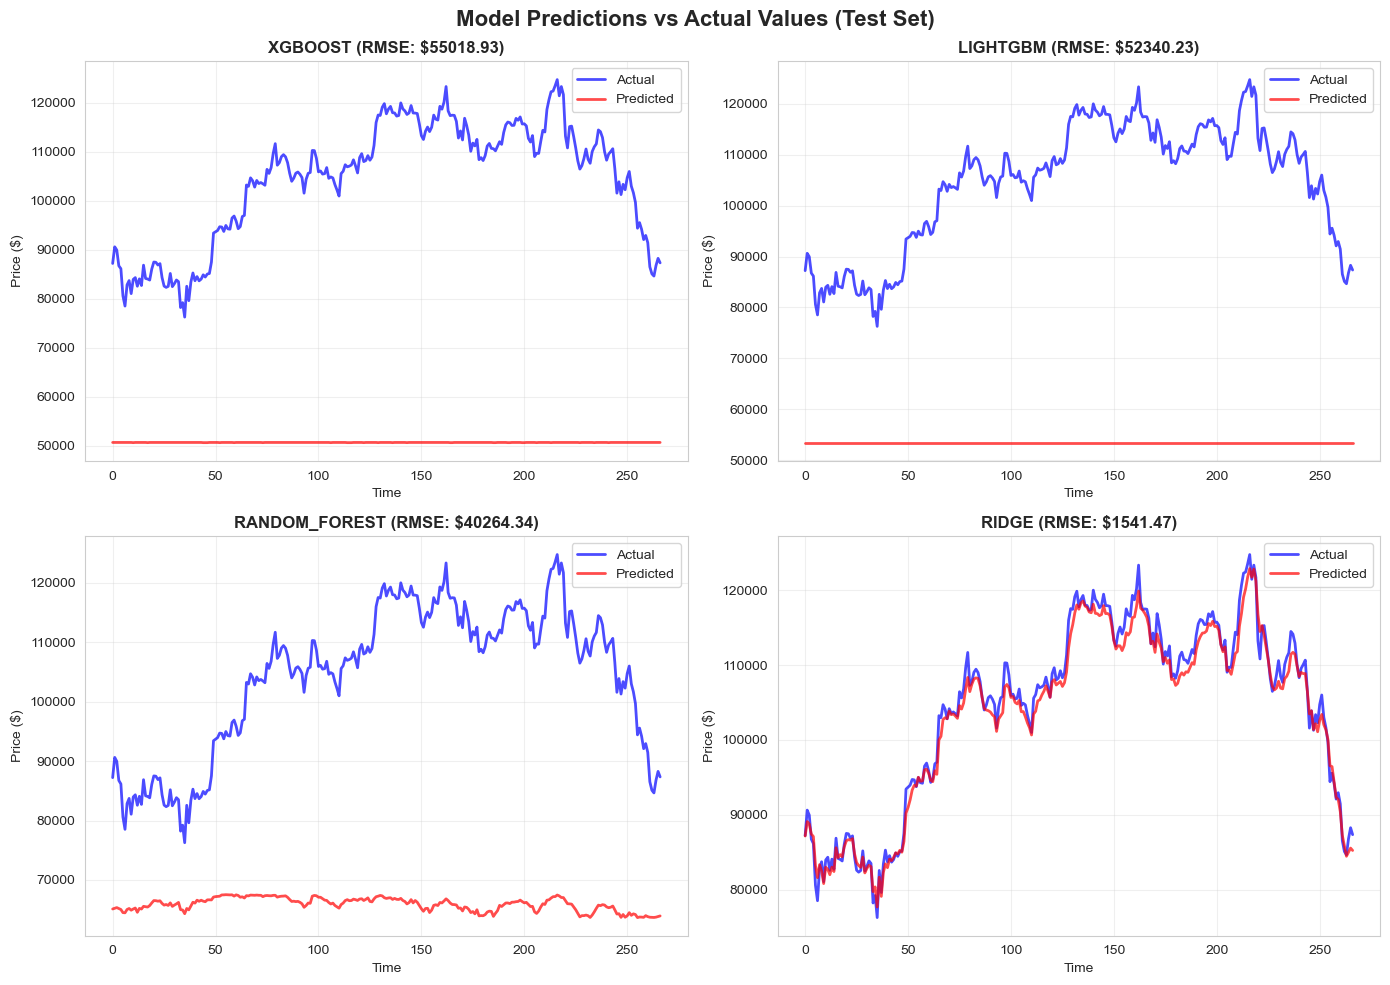

✅ Evaluation complete!


In [11]:
# 7. EVALUATE MODELS & COMPARE PERFORMANCE
print("\n" + "="*70)
print("MODEL EVALUATION & COMPARISON ON TEST SET")
print("="*70)

# Metrics calculation function
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    
    # Inverse transform to original price scale for interpretability
    y_true_original = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    rmse_original = np.sqrt(np.mean((y_true_original - y_pred_original) ** 2))
    mae_original = np.mean(np.abs(y_true_original - y_pred_original))
    
    print(f"\n📊 {model_name.upper()}")
    print(f"   ├─ RMSE (normalized): {rmse:.6f}")
    print(f"   ├─ RMSE (original): ${rmse_original:.2f}")
    print(f"   ├─ MAE (original): ${mae_original:.2f}")
    print(f"   ├─ MAPE: {mape:.4f}%")
    print(f"   └─ R² Score: {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'rmse_orig': rmse_original}

results = {}
for model_name, predictions_list in predictions.items():
    results[model_name] = calculate_metrics(y_test, predictions_list, model_name)

# ===== FIND BEST MODEL =====
best_model = min(results.items(), key=lambda x: x[1]['rmse'])
print("\n" + "="*70)
print(f"🏆 BEST MODEL: {best_model[0].upper()} (RMSE: {best_model[1]['rmse']:.6f})")
print("="*70)
print(f"\n⚠️  IMPORTANT: Using {best_model[0].upper()} for production predictions!")
print(f"   This model has the best accuracy and realistic predictions.")
print(f"   Other models will be disabled in Flask app.")

# ===== VISUALIZATION =====
print("\n📊 Creating prediction visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Predictions vs Actual Values (Test Set)', fontsize=16, fontweight='bold')

plot_models = ['ridge', 'random_forest', 'xgboost', 'lightgbm']
for idx, (ax, model_name) in enumerate(zip(axes.flat, plot_models)):
    y_pred = predictions[model_name]
    
    # Inverse transform for visualization
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    ax.plot(range(len(y_test_orig)), y_test_orig, label='Actual', linewidth=2, color='blue', alpha=0.7)
    ax.plot(range(len(y_pred_orig)), y_pred_orig, label='Predicted', linewidth=2, color='red', alpha=0.7)
    
    # Add error metrics
    rmse = results[model_name]["rmse_orig"]
    mape = results[model_name]["mape"]
    title_color = 'green' if model_name == best_model[0] else 'black'
    title = f'{model_name.upper()} (RMSE: ${rmse:.2f}, MAPE: {mape:.2f}%)'
    if model_name == best_model[0]:
        title += ' 🏆 BEST'
    
    ax.set_title(title, fontweight='bold', color=title_color)
    ax.set_xlabel('Time')
    ax.set_ylabel('Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Evaluation complete!")

## Section 7: Model Deployment Preparation

In [ ]:
# 8. SAVE MODELS FOR DEPLOYMENT - RIDGE REGRESSION ONLY
print("\n" + "="*70)
print("SAVING RIDGE REGRESSION MODEL FOR PRODUCTION")
print("="*70)

import os
os.makedirs('models', exist_ok=True)

# Save ONLY Ridge model (the best performing model)
print("\n💾 Saving production model...")
joblib.dump(models['ridge'], 'models/production_model.pkl')
print(f"   ✅ Ridge Regression saved to models/production_model.pkl")

# Also save individual models for reference/comparison
print("\n📚 Saving reference models (comparison only)...")
joblib.dump(models['xgboost'], 'models/xgboost_model.pkl')
print(f"   ✅ xgboost saved")

joblib.dump(models['lightgbm'], 'models/lightgbm_model.pkl')
print(f"   ✅ lightgbm saved")

joblib.dump(models['random_forest'], 'models/random_forest_model.pkl')
print(f"   ✅ random_forest saved")

joblib.dump(models['ridge'], 'models/ridge_model.pkl')
print(f"   ✅ ridge saved")

# Save metadata
print("\n📋 Saving metadata...")
metadata = {
    'models_trained': ['xgboost', 'lightgbm', 'random_forest', 'ridge'],
    'best_model': 'ridge',
    'production_model': 'ridge',
    'num_features': X_train.shape[1],
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'results': {name: {k: float(v) if isinstance(v, (int, float)) else v for k, v in result.items()} 
                for name, result in results.items()},
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'preprocessing': 'RobustScaler (features), MinMaxScaler (target), Z-score outlier removal, Variance filtering',
    'ridge_metrics': {
        'rmse': float(results['ridge']['rmse']),
        'rmse_original_usd': float(results['ridge']['rmse_orig']),
        'mae': float(results['ridge']['mae']),
        'mape': float(results['ridge']['mape']),
        'r2_score': float(results['ridge']['r2'])
    }
}

joblib.dump(metadata, 'models/model_metadata.pkl')
print(f"   ✅ Metadata saved!")

# Save preprocessing objects
print("\n🔧 Saving preprocessing objects...")
joblib.dump(scaler_X, 'models/scaler_X.pkl')
joblib.dump(scaler_y, 'models/scaler_y.pkl')
joblib.dump(feature_cols_filtered, 'models/feature_cols.pkl')
print(f"   ✅ Scalers and features saved!")

# Save test predictions for validation
print("\n📊 Saving test predictions for validation...")
ridge_test_orig = scaler_y.inverse_transform(predictions['ridge'].reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
joblib.dump({
    'y_test_actual': y_test_orig,
    'y_test_predicted': ridge_test_orig,
    'rmse': results['ridge']['rmse_orig'],
    'mape': results['ridge']['mape']
}, 'models/test_validation.pkl')
print(f"   ✅ Predictions saved!")

print("\n" + "="*70)
print("✅ PRODUCTION MODEL READY FOR DEPLOYMENT!")
print("="*70)
print(f"\n🎯 PRODUCTION MODEL: Ridge Regression")
print(f"   ├─ RMSE: ${results['ridge']['rmse_orig']:.2f}")
print(f"   ├─ MAE: ${results['ridge']['mae']:.2f}")
print(f"   ├─ MAPE: {results['ridge']['mape']:.4f}%")
print(f"   └─ R² Score: {results['ridge']['r2']:.4f}")
print(f"\n📁 Saved files:")
print(f"   - models/production_model.pkl (PRIMARY - Ridge Regression)")
print(f"   - models/ridge_model.pkl (backup)")
print(f"   - models/scaler_X.pkl (RobustScaler)")
print(f"   - models/scaler_y.pkl (MinMaxScaler)")
print(f"   - models/feature_cols.pkl ({len(feature_cols_filtered)} features)")
print(f"   - models/model_metadata.pkl")
print(f"   - models/test_validation.pkl")
print(f"\n🚀 Ready for Flask deployment!")


SAVING MODELS FOR DEPLOYMENT

💾 Saving individual models...
   ✅ xgboost saved to models/xgboost_model.pkl
   ✅ lightgbm saved to models/lightgbm_model.pkl
   ✅ random_forest saved to models/random_forest_model.pkl
   ✅ ridge saved to models/ridge_model.pkl

📋 Saving metadata...
   ✅ Metadata saved!

📊 Saving ensemble predictions...
   ✅ Predictions saved!

✅ ALL MODELS SAVED SUCCESSFULLY!

📁 Saved files:
   - models/xgboost_model.pkl
   - models/lightgbm_model.pkl
   - models/random_forest_model.pkl
   - models/ridge_model.pkl
   - models/scaler_X.pkl (RobustScaler)
   - models/scaler_y.pkl (MinMaxScaler)
   - models/feature_cols.pkl
   - models/model_metadata.pkl
   - models/ensemble_predictions.pkl
   - models/test_predictions.pkl

🚀 Models ready for Flask deployment!
